## Section 1 

In [4]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")
import display_tools
from display_tools import display_da
from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl


## Section 2 Select your area of interest

In [5]:
# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widget to display coordinates
output = Output(layout={'border': '1px solid black', 'padding': '5px'})

# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    # Ensure consistent ordering of coordinates (assuming lon-lat order)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output:
        output.append_stdout("Coordinates:\n")
        output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    draw_control.clear()
    output.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None

clear_button_draw.on_click(clear_all)
clear_button_manual.on_click(clear_all)

# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output:
            output.append_stdout("Manual Coordinates:\n")
            output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output:
            output.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Tab widget for drawing and manual input
draw_tab = VBox([clear_button_draw, output])
manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output])

tab = Tab()
tab.children = [draw_tab, manual_tab]
tab.set_title(0, 'Draw')
tab.set_title(1, 'Manual Input')

# Add the tab control to the map
tab_control = WidgetControl(widget=tab, position='topright')
m.add_control(tab_control)

# Display the map
display(m)



Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

## Section 3  Select you

The drawn shape was used for selection.
The geopolygon of interest is the following one; 
POLYGON ((150.711608 -23.575473, 150.711608 -23.554703, 150.727401 -23.554703, 150.727401 -23.575473, 150.711608 -23.575473))

Selected Polygon Coordinates:
Latitude: -23.575473, Longitude: 150.711608
Latitude: -23.554703, Longitude: 150.711608
Latitude: -23.554703, Longitude: 150.727401
Latitude: -23.575473, Longitude: 150.727401
Latitude: -23.575473, Longitude: 150.711608

UTM Coordinates:
UTM X: 5338298.3570450265, UTM Y: -16519050.955446463
UTM X: 5339390.991363663, UTM Y: -16521841.67369766
UTM X: 5337434.6945548635, UTM Y: -16522607.082156857
UTM X: 5336342.801212065, UTM Y: -16519816.707567314
UTM X: 5338298.3570450265, UTM Y: -16519050.955446463


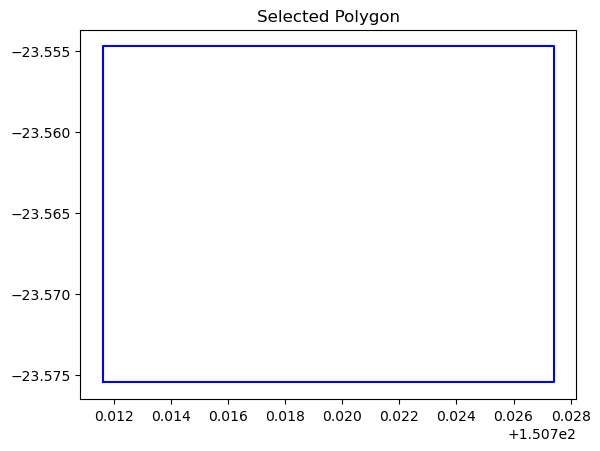

In [6]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=33, datum="WGS84")  # Change zone as needed
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

        print("The drawn shape was used for selection.")
        print("The geopolygon of interest is the following one; ")
        print(selected_polygon)

        print("\nSelected Polygon Coordinates:")
        for lon, lat in coords:
            print(f"Latitude: {lat}, Longitude: {lon}")

        print("\nUTM Coordinates:")
        for utm_x, utm_y in utm_coords:
            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)


## Section 4

In [7]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


## Section 5 - Load data from datacube

#### Intertidal elevation

In [8]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Load and mask the Intertidal Elevation products (select measurement = elevation, elevation_uncertainty and exposure)
item = dc.load(
    product="ga_s2ls_intertidal_cyear_3", 
    output_crs="EPSG:3577",  
    resolution=(-25, 25),
    **query   
    )  

item = mask_invalid_data(item)
item = item.where(item!=0)

Lat Range: (-23.575473, -23.554703)
Lon Range: (150.711608, 150.727401)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-23.575473, -23.554703), 'x': (150.711608, 150.727401), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}


In [9]:
bounds = np.array([10, 10, 40, 40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
print(norm([10,40]))
#norm = mpl.colors.Normalize(vmin=2, vmax=200)
#norm(0)

[49 100]


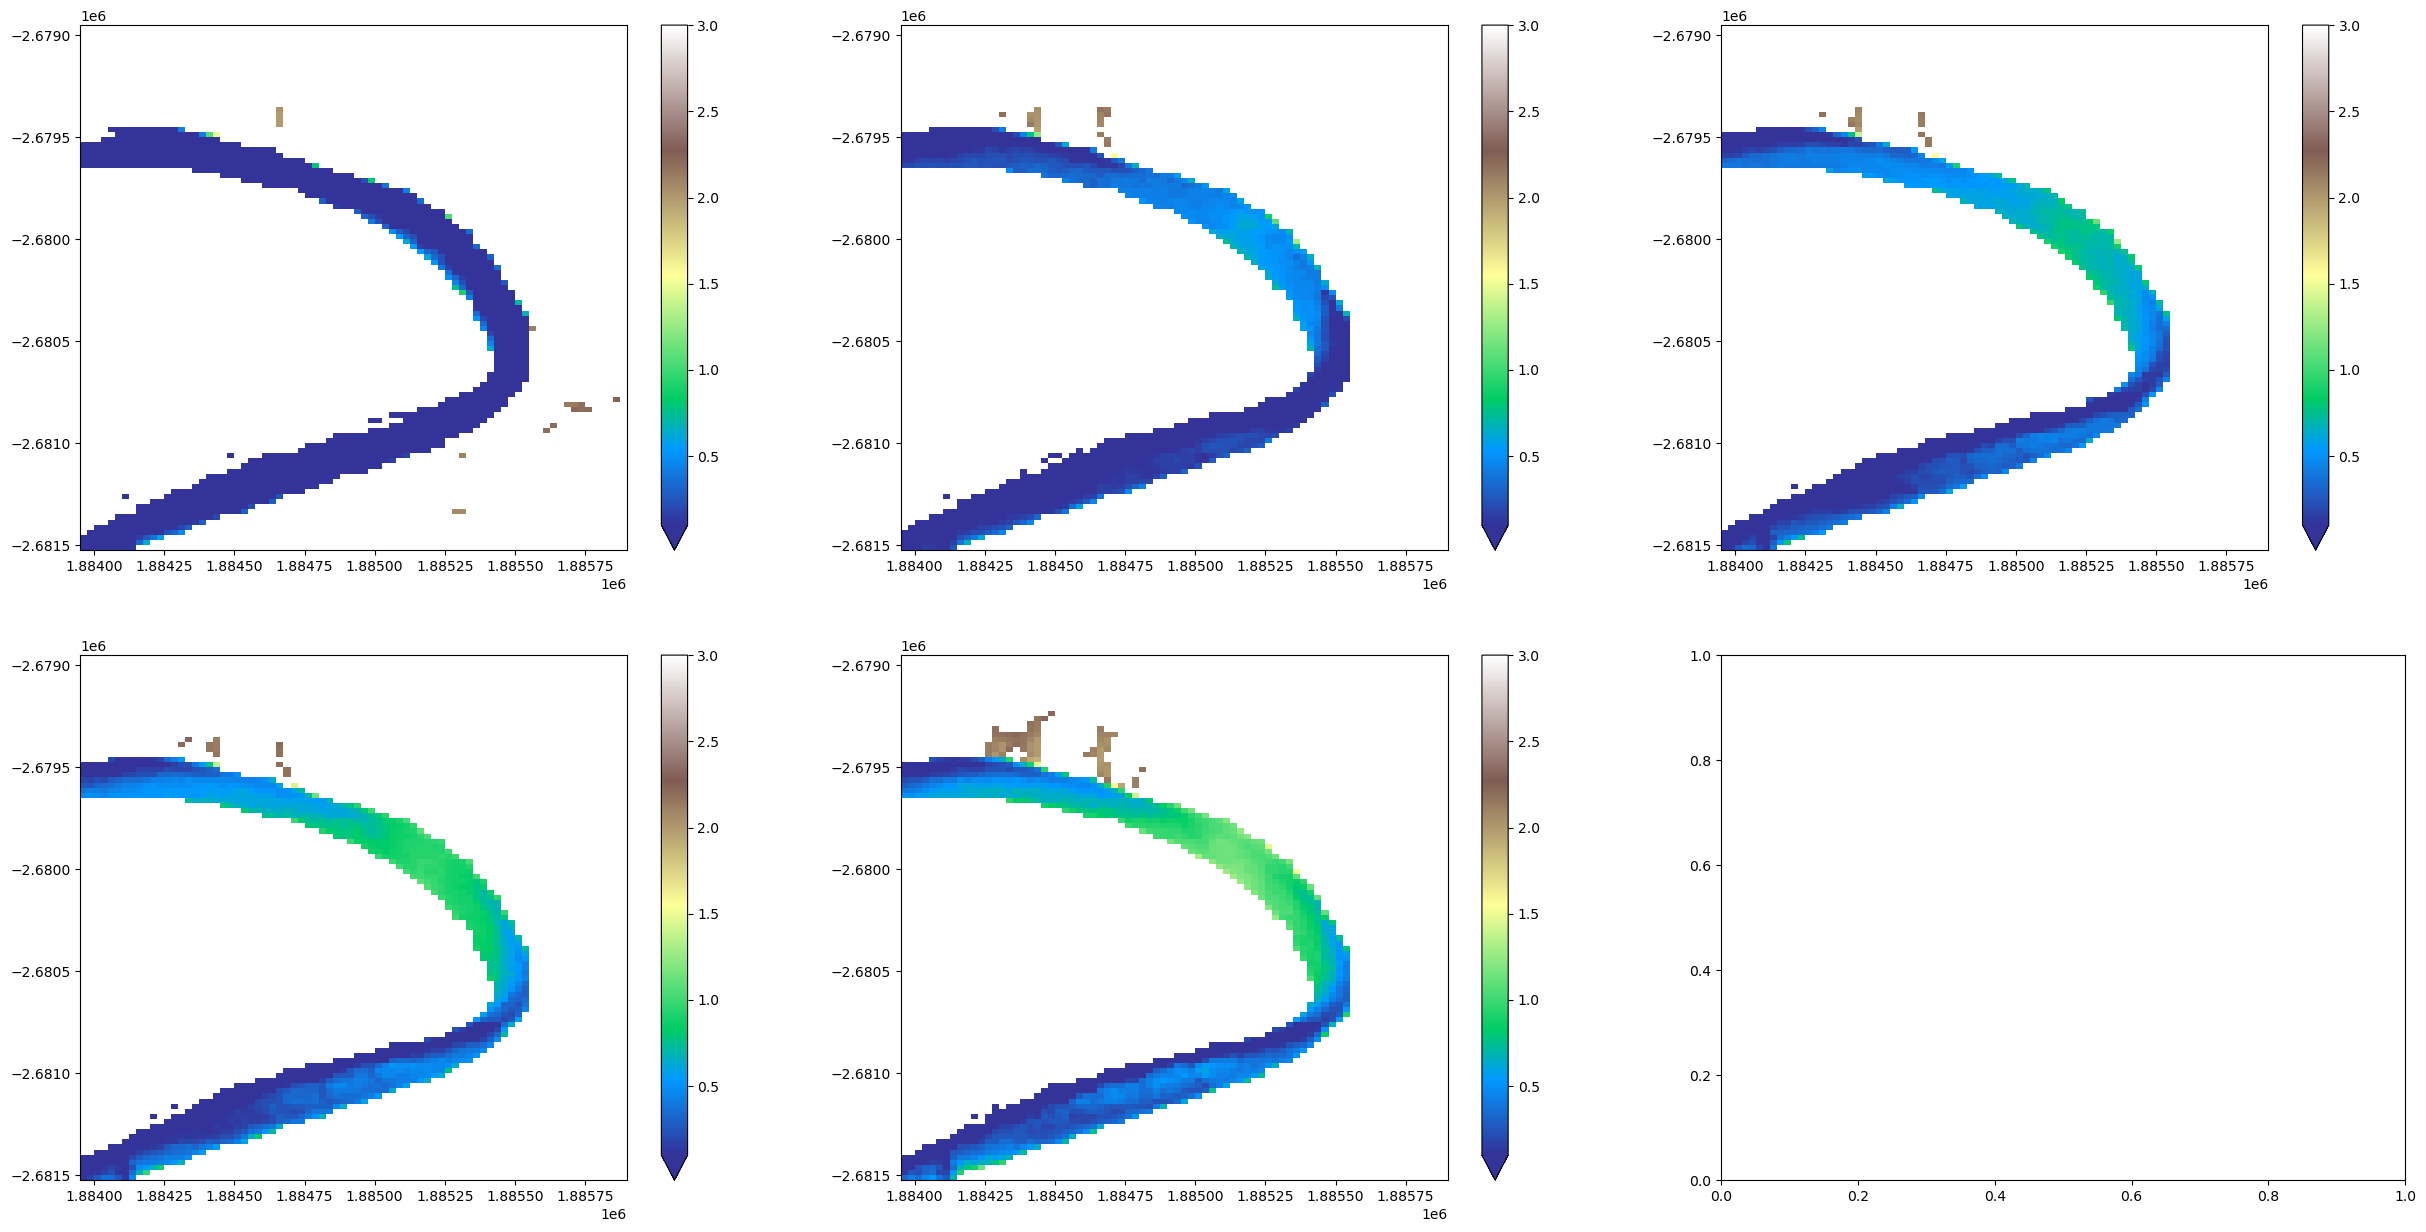

In [10]:
item_fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 15))
item.elevation[0].plot(ax=axs[0,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[1].plot(ax=axs[0,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[2].plot(ax=axs[0,2], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[3].plot(ax=axs[1,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[4].plot(ax=axs[1,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')

In [11]:
item

<xarray.Dataset> Size: 2MB
Dimensions:                (time: 5, y: 103, x: 78)
Coordinates:
  * time                   (time) datetime64[ns] 40B 2016-07-01T23:59:59.9999...
  * y                      (y) float64 824B -2.679e+06 -2.679e+06 ... -2.682e+06
  * x                      (x) float64 624B 1.884e+06 1.884e+06 ... 1.886e+06
    spatial_ref            int32 4B 3577
Data variables:
    elevation              (time, y, x) float32 161kB nan nan nan ... nan nan
    elevation_uncertainty  (time, y, x) float32 161kB nan nan nan ... nan nan
    exposure               (time, y, x) float32 161kB nan nan nan ... nan nan
    ta_hat                 (time, y, x) float32 161kB 2.935 2.935 ... 2.991
    ta_hot                 (time, y, x) float32 161kB 2.815 2.815 ... 2.855
    ta_lot                 (time, y, x) float32 161kB -1.556 -1.556 ... -1.364
    ta_lat                 (time, y, x) float32 161kB -2.705 -2.705 ... -2.697
    ta_offset_high         (time, y, x) float32 161kB 2.0 2.0 2.0 ... 2.0 2.0
    ta_offset_low          (time, y, x) float32 161kB 20.0 20.0 ... 23.0 23.0
    ta_spread              (time, y, x) float32 161kB 77.0 77.0 ... 74.0 74.0
    qa_ndwi_corr           (time, y, x) float32 161kB nan nan ... 0.1948 0.1951
    qa_ndwi_freq           (time, y, x) float32 161kB nan nan nan ... 2.0 2.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Trend analysis of intertidal elevation

In [23]:
# Reshaping the 3D array (i.e., year, longitude, latitude) to a 2D array (i.e., year, pixel)
item_elevation_2d = item.elevation.values[0], item.elevation.values[1]*item.elevation.values[0][-1]

TypeError: type tuple doesn't define __round__ method

In [20]:
def mk_pixel_pvalue(pixel):
    result = mk.original_test(item_elevation_2d[pixel])
    return result.p

def mk_pixel_trend_slope(pixel):
    result = mk.original_test(item_elevation_2d[pixel])
    return result.slope

pixel_pvalues = list(map(mk_pixel_pvalue, range(item.elevation.values[0])))
pixel_trend_slopes = list(map(mk_pixel_trend_slope, range(item.elevation.values[0])))

TypeError: only integer scalar arrays can be converted to a scalar index

In [18]:
item_elevation_2d

(array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.7259963 , -0.6492223 , -0.62654555, ...,         nan,
                 nan,         nan],
        [-0.614815  , -0.5717447 , -0.5503642 , ...,         nan,
                 nan,         nan],
        [-0.53458303, -0.40166417, -0.39923474, ...,         nan,
                 nan,         nan]], dtype=float32),
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.2655458 ,  0.14945753,  0.1

In [19]:
# Reshaping the 1D "pixel" p.value array to a 2D "long/lat" p.value array
px_pvalues_narray =np.array(pixel_pvalues).reshape(item_elevation_2d.values[1], item_elevation_2d.values[2])

# Creating an xarray from numpy array
px_pvalues_xr = xr.DataArray(px_pvalues_narray, 
    coords={'x': pv_annual_med.x,'y': pv_annual_med.y}, 
    dims=["x", "y"])

NameError: name 'pixel_pvalues' is not defined

In [24]:
# Plotting pixel p.value where significant trend is detected (used pvalue=0.05 for the example but can change to 0.01)
px_pvalues_xr.where(px_pvalues_xr<0.5).plot()

NameError: name 'px_pvalues_xr' is not defined

In [25]:
# Reshaping the 1D "pixel" slope array to a 2D "long/lat" slope array
px_trend_slopes_narray =np.array(pixel_trend_slopes).reshape(item_elevation_2d.values[1], item_elevation_2d.values[2])

# Creating an xarray from numpy array
px_trend_slopes_xr = xr.DataArray(px_trend_slopes_narray, 
    coords={'x': pv_annual_med.x,'y': pv_annual_med.y}, 
    dims=["x", "y"])

NameError: name 'pixel_trend_slopes' is not defined

In [ ]:
# Plotting slope values where significant trend is detected
px_trend_slopes_xr.where(px_pvalues_xr<0.9).plot()